# Stochastic rotations

Computing DPS distributions and moments for stochastic rotations is currently not built into `ffxiv_stats`, but can still be done with a bit of extra code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import binom
from scipy.stats import skewnorm
from scipy.signal import fftconvolve

import ffxiv_stats as ffs
from ffxiv_stats.moments import Rotation


## Random number of hits

Example showing 7 Lord of Crown draws, where the total number of hits is binomially distributed with p = 0.5 and n = 7.

The general strategy is to loop through all possible number of hits, `[0, 1, 2, ..., 7]`, and compute the sub-DPS distribution for each number of hits. A mixture distribution is then created the sub-distributions and the corresponding binomial weight.

The figure below shows all possible DPS distributions for n = 0, 1, ..., 7 and the corresponding binomial weight before the mixture distribution is created.

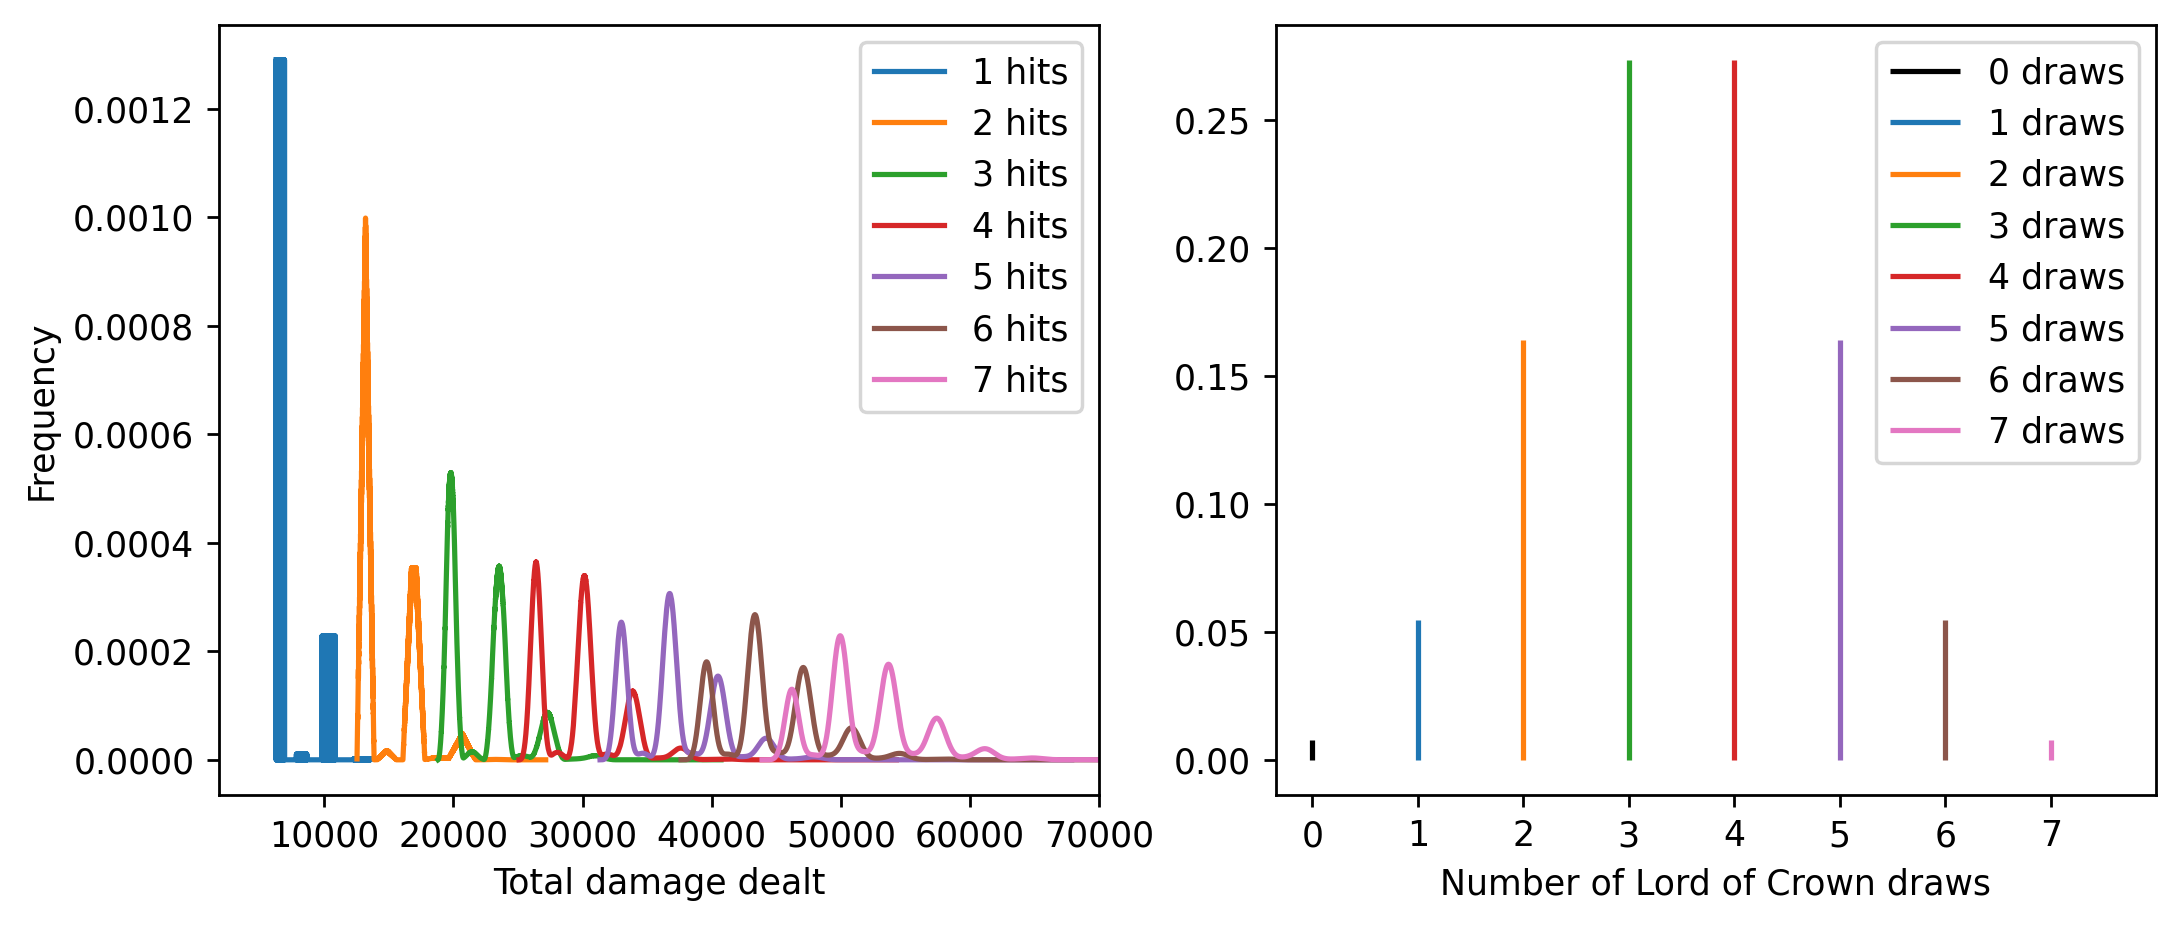

In [2]:
n_hits = 7
dps = []
p = []
a = ffs.Rate(1989, 436)

rotation = pd.DataFrame({
    'd2': [6000],
    'n': [7],
    'p': [a.p],
    'l_c': [a.l_c],
    'buffs': [[1.1]],
    'is_dot': [0],
    'action_name': ['Lord of Crowns'],
    'base_action': ['Lord of Crowns']})

# set t = 1 for total damage dealt
t = 1

fig, ax = plt.subplots(1, 2, figsize=(10,4), dpi=250)
binom_weights = binom(n_hits, 0.5).pmf(np.arange(n_hits+1)).reshape((n_hits+1,1))
ax[1].vlines(0, 0, binom_weights[0][0], color='k', label='0 draws')        

for n in np.arange(1, n_hits+1):
    rotation['n'].update(n)
    r = Rotation(rotation, t)

    a, b = r.convolve_pmf(0)
    dps.append(a)
    p.append(b)

    ax[0].plot(dps[n-1], p[n-1], label=f'{n} hits')
    
    ax[1].vlines(n, 0, binom_weights[n][0], color=f'C{n-1}', label=f'{n} draws')


ax[0].set_xlim([ax[0].get_xlim()[0], 70000])
ax[0].set_xlabel('Total damage dealt')
ax[1].set_xlabel('Number of Lord of Crown draws')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[1].legend()
ax[1].set_xlim([ax[1].get_xlim()[0], 8])
ax[1].set_xticks(np.arange(0,8))
plt.show()


Now they are mixed together. Note that n = 0 is a special case and is handled separately. 

Text(0.5, 0, 'Damage per second (DPS)')

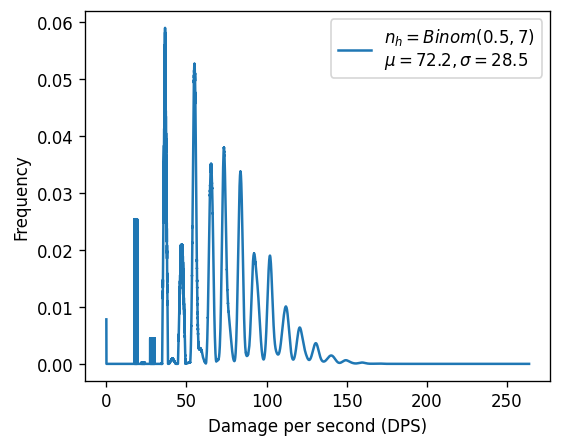

In [3]:
# We need to make a support that spans from the smallest possible damage dealt (0 from no hits)
# to the highest possible damage dealt, n = 7, all crit-direct hits with a +5% damage roll.
big_grid = np.arange(0, max([np.max(d) for d in dps])+1)

# Now we need to map the probability arrays to the corresponding index in the big_grid support
h = np.zeros((n_hits+1, big_grid.size))
for a in range(1, n_hits+1):
    h[a, np.isin(big_grid, dps[a-1])] = p[a-1]
h[0, 0] = 1

t = (n_hits-1) * 60

# Weights for the mixture distribution
binom_weights = binom(n_hits, 0.5).pmf(np.arange(n_hits+1)).reshape((n_hits+1,1))
# Element-wise multiplication with the weights, then get sums for each column for the overall dps distribution
p_total = np.sum(h * binom_weights, axis=0)

# First two moments
mu = np.dot(big_grid, p_total)
sigma = np.sqrt(np.dot(p_total, (big_grid - mu)**2)) / t

# Total damage dealt to DPS
big_grid /= t
p_total *= t
# We have to handle the n = 0 hit specially for it to be properly normalized.
p_total[0] = binom_weights[0][0]

fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=120)
plt.plot(big_grid, p_total, label=f'$n_h = Binom(0.5, 7)$\n$\mu = {mu/t:.1f}, \sigma = {sigma:.1f}$')
ax.legend()
ax.set_ylabel('Frequency')
ax.set_xlabel('Damage per second (DPS)')


Generally, we are interested in the overall rotation. The stochastic portion of the DPS distribution can readily be convolved with a the deterministic portion of the DPS distribution from a deterministic rotation. Here, Fall Malefic casts and Combust DoT ticks compose the deterministic portion of the rotation.

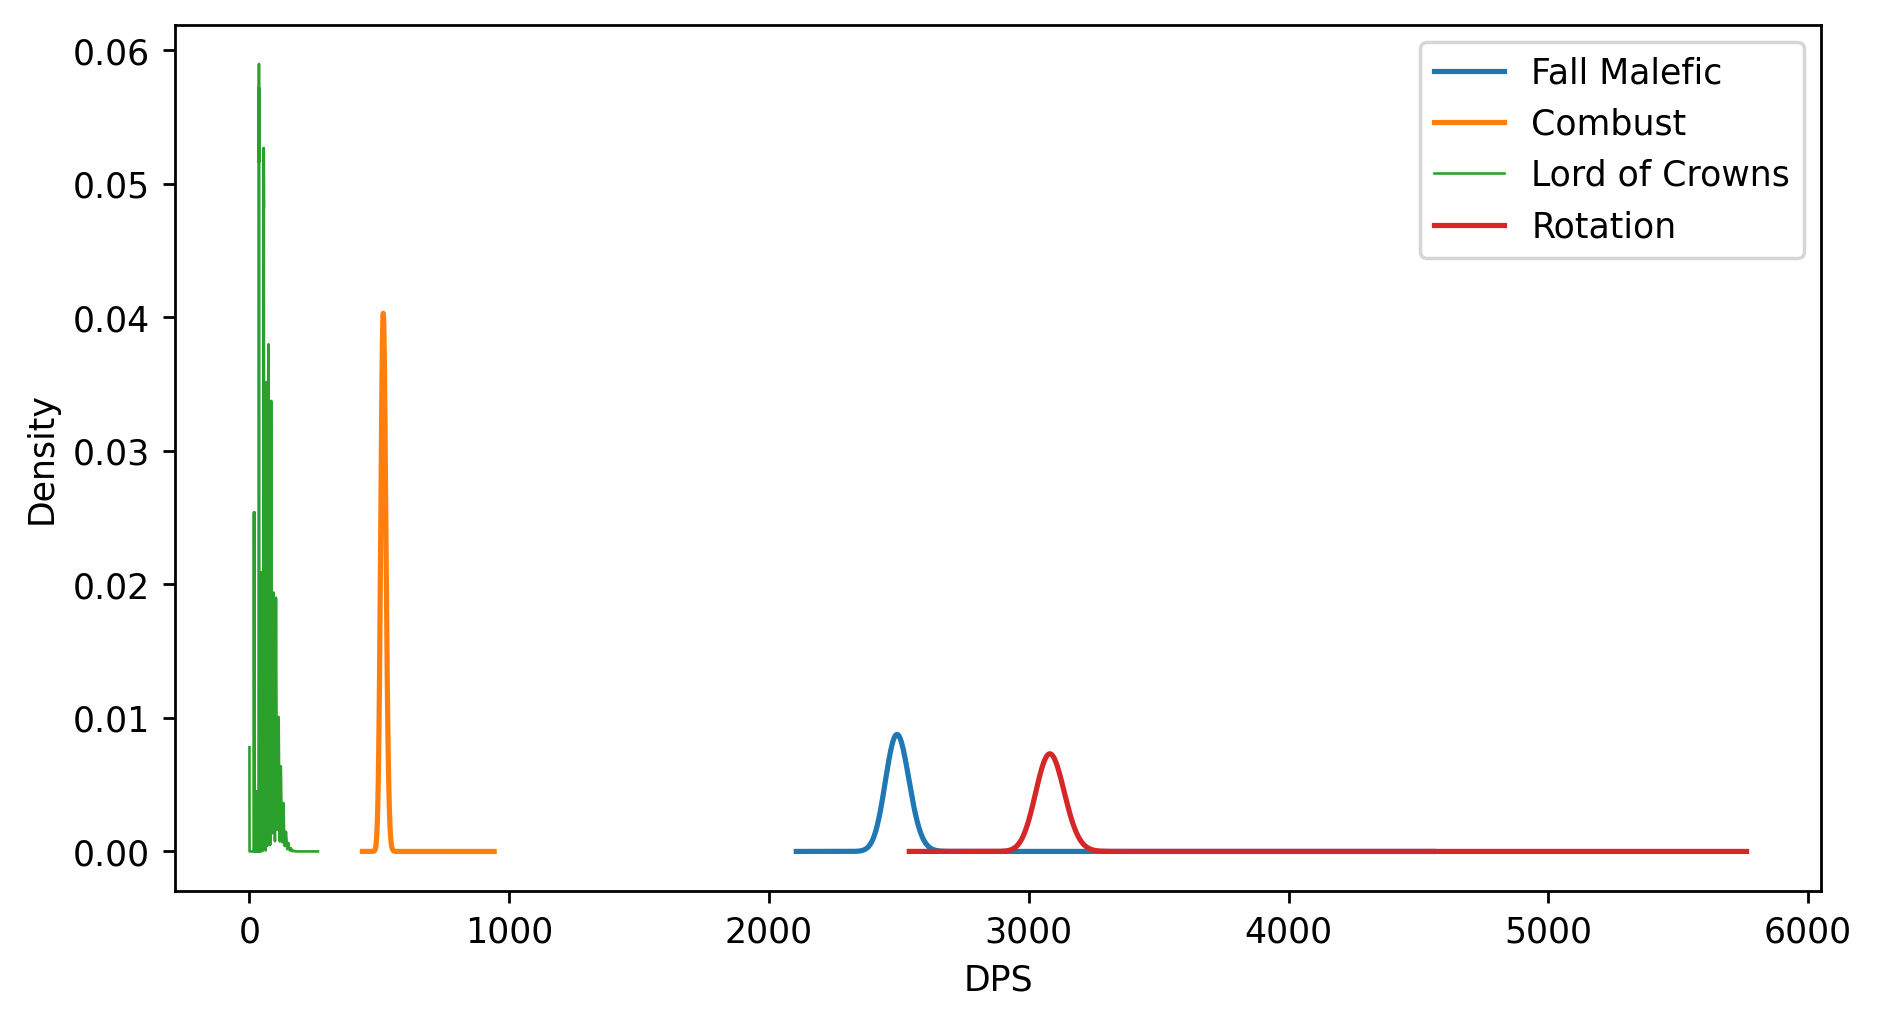

In [4]:
a = ffs.Rate(1989, 436)
t = (n_hits-1) * 60
full_rotation = pd.DataFrame({
    'd2': [6000, 1375],
    'n': [133, 120],
    'p': [a.p]*2,
    'l_c': [a.l_c]*2,
    'buffs': [None, None],
    'is_dot': [0, 1],
    'action_name': ['Fall Malefic', 'Combust'],
    'base_action': ['Fall Malefic', 'Combust']
    })

full_r = Rotation(full_rotation, t)

fig, ax = plt.subplots(1, 1, figsize=(8.5,4.5), dpi=250)
for x in range(2):
    ax.plot(full_r.action_dps_support[x], full_r.action_dps_distributions[x], label=full_rotation['action_name'][x])
ax.plot(big_grid, p_total, label='Lord of Crowns', linewidth=0.75)

# Combine stochastic and deterministic portions
# Care must be taken to convolve the two distributions on a common support, as seen by the interpolation.
delta = 0.5
s_support = np.arange(0, int(big_grid[-1]) + delta, step=delta)
s_dps_dist = np.interp(s_support, big_grid, p_total)
rotation_supp = np.arange(s_support[0] + full_r.rotation_dps_support[0], full_r.rotation_dps_support[-1] + s_support[-1] + delta, step=delta)

# Multiply by delta to ensure the distribution is normalized.
ax.plot(rotation_supp, fftconvolve(s_dps_dist, full_r.rotation_dps_distribution)*delta, label='Rotation')

ax.legend()
ax.set_xlabel('DPS')
ax.set_ylabel('Density')
plt.show()

## Randomly distributed buffs aka Astrodyne

This case is more computationally expensive since we must enumerate over all possible paths, which grows combinatorically. For 5 astrodyne usages with 3 different possible unique seal counts, there are 243 unique paths. Although it is still computationally tractable, it is still an order of magnitude more expensive to compute than a solely deterministic rotation. 



In [5]:
from itertools import product

print(f'For 5 Astrodyne usages, there are {len(list(product((1, 2, 3), repeat=5)))} unique paths')

For 5 Astrodyne usages, there are 243 unique paths


In [53]:
def sequence_enumerate(iterable):
    """
    
    """
    a = ffs.Rate(1989, 436)
    # These are the weights of attaining a 1, 2, and 3 unique seals.
    # I think this is from an MC sim where redraw is performed if the current card doesn't increase the unique seal count.
    # This is also from 6.0 where redrawing did not guarantee a unique seal
    w = np.array([0.005, 0.435, 0.560])
    dmg = []
    p = []
    path_prob = []
    t = 1
    # Not the most elegant way but whatever
    iter_len = len(list(iterable))
    print(iter_len)
    for i, x in enumerate(list(iterable)):
        print(i, x)
        path_prob.append(np.prod(w[np.array(x)-1]))

        n_1_seal = np.count_nonzero(np.array(x) == 1)
        n_2_seal = np.count_nonzero(np.array(x) == 2)
        n_3_seal = np.count_nonzero(np.array(x) == 3)

        # Some simple math to compute the number of hits depending if the haste buff is present.
        # IMPORTANT: The haste buff is significantly faster than what is actually in FFXIV
        # One extra GCD is granted under this haste buff, which is done to make the counting/math simple.
        buffed_hits = 10 * n_3_seal
        base_hits = (28*4 + 4) + 8*n_1_seal + 10*n_2_seal

        rotation = pd.DataFrame({
            'd2': [5000, 5000],
            'n': [base_hits, buffed_hits],
            'p': [a.p, a.p],
            'l_c': [a.l_c, a.l_c],
            'buffs': [None, [1.05]],
            'is_dot': [0, 0],
            'action_name': ['Fall Malefic', 'Buff Fall Malefic'],
            'base_action': ['Fall Malefic', 'Fall Malefic']
            })
        rotation = rotation[rotation.n != 0]
        # display(rotation)
        r = Rotation(rotation, t)

        alpha, omega, squigma = r.moments_to_skew_norm(r.rotation_mean, r.rotation_mean, r.rotation_skewness)
        supp = np.arange(np.floor(r.rotation_mean - 5 * r.rotation_std), 
                    np.floor(r.rotation_mean + 5 * r.rotation_std))
        y = skewnorm.pdf(supp, alpha, squigma, omega)

        dmg.append(supp)
        p.append(y)
        print(f"On loop {i}/{iter_len}", end="\r")       
    return dmg, p, np.array(path_prob)

Here, all the paths are generated and the DPS distribution + probability of each path is calculated. These will be mixed together below.

In [54]:
dmg

[]

In [55]:
dmg, p, path_prob = sequence_enumerate(product((1, 2, 3), repeat=5))

243


The figure below shows the individuals sub-distributions resulting from each path on the left. On the right shows the resulting mixture distribution when they are weighted by the path probability.

ValueError: min() arg is an empty sequence

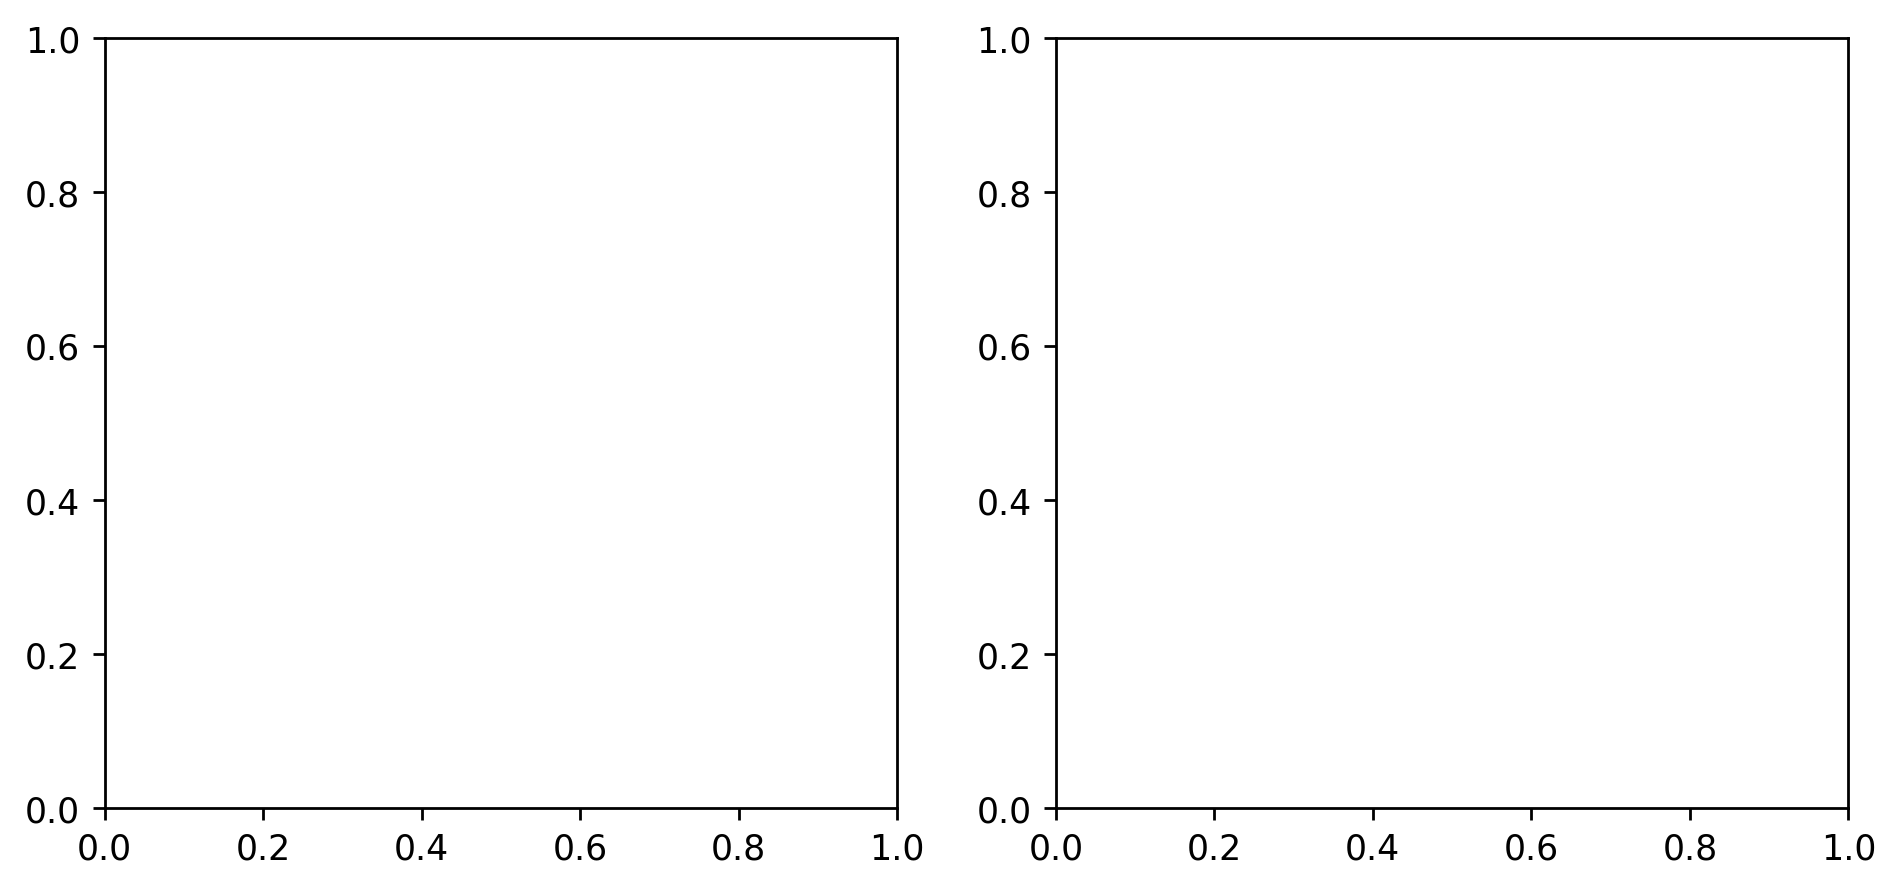

In [38]:
fig, ax = plt.subplots(1,2, figsize=(9,4), dpi=250)
n_hits = len(path_prob)
big_grid = np.arange(min([np.min(d) for d in dmg]), max([np.max(d) for d in dmg])+1)
h = np.zeros((n_hits, big_grid.size))
for a in range(n_hits):
    h[a, np.isin(big_grid, dmg[a])] = p[a]
    ax[0].plot(big_grid / 390, h[a] * 390)

ax[0].set_xlim([2200, 2500])
ax[1].set_xlim([2200, 2500])
ax[1].set_xlabel('DPS')
ax[0].set_xlabel('DPS')
ax[0].set_ylabel('Frequency')


path_prob = np.array(path_prob).reshape((len(path_prob),1))
p_total = np.sum(h * path_prob, axis=0)
ax[1].plot(big_grid / 390, p_total * 390)
plt.tight_layout()
plt.show()

However, it only looks like theres about 20 sub-distributions in the above figure, not 200. This is because many of the sub-distributions are the same. What only matters is the total number of 1, 2, 3 seal Astrodynes, not their particular order. We can drastically reduce the number of DPS distributions that need to be computed by utilizing that, as shown below.

In [27]:
hits, counts = np.unique(np.sort(np.array(list(product((1, 2, 3), repeat=5))), axis=1), axis=0, return_counts=True)
dmg, p, path_prob = sequence_enumerate(hits)

Number of unique seals for each Astrodyne: [1 1 1 1 1]
Probability of each unique seal count: ', [0.005 0.005 0.005 0.005 0.005]
Total path probability: ', 3.1250000000000005e-12Number of unique seals for each Astrodyne: [1 1 1 1 2]
Probability of each unique seal count: ', [0.005 0.005 0.005 0.005 0.435]
Total path probability: ', 2.7187500000000006e-10Number of unique seals for each Astrodyne: [1 1 1 1 3]
Probability of each unique seal count: ', [0.005 0.005 0.005 0.005 0.56 ]
Total path probability: ', 3.500000000000001e-10Number of unique seals for each Astrodyne: [1 1 1 2 2]
Probability of each unique seal count: ', [0.005 0.005 0.005 0.435 0.435]
Total path probability: ', 2.3653125000000004e-08Number of unique seals for each Astrodyne: [1 1 1 2 3]
Probability of each unique seal count: ', [0.005 0.005 0.005 0.435 0.56 ]
Total path probability: ', 3.0450000000000005e-08Number of unique seals for each Astrodyne: [1 1 1 3 3]
Probability of each unique seal count: ', [0.005 0.005 0

KeyboardInterrupt: 

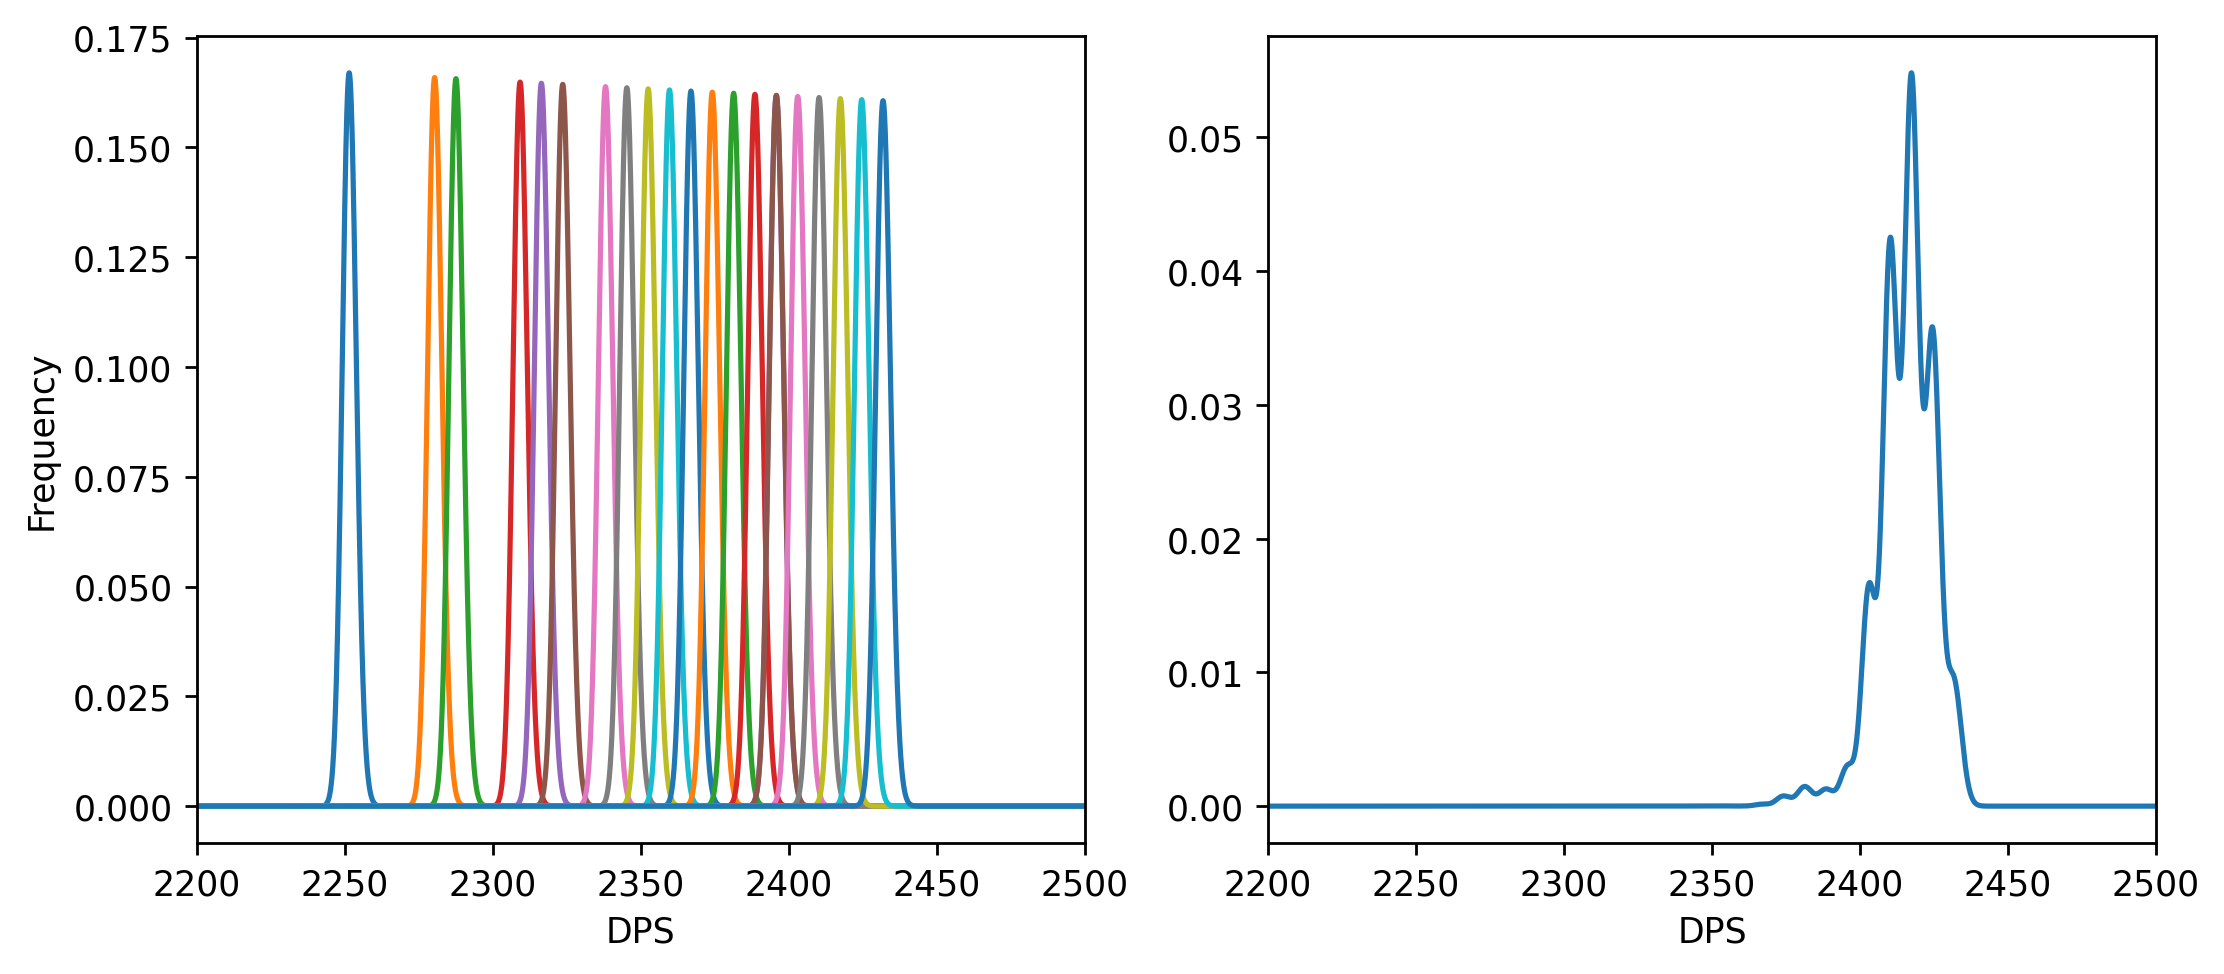

In [19]:
fig, ax = plt.subplots(1,2, figsize=(9,4), dpi=250)
n_hits = len(path_prob)
big_grid = np.arange(min([np.min(d) for d in dmg]), max([np.max(d) for d in dmg])+1)
h = np.zeros((n_hits, big_grid.size))
for a in range(n_hits):
    h[a, np.isin(big_grid, dmg[a])] = p[a]
    ax[0].plot(big_grid / 390, h[a] * 390)

ax[1].set_xlim([2200, 2500])
ax[0].set_xlim([2200, 2500])
ax[0].set_xlabel('DPS')
ax[1].set_xlabel('DPS')
ax[0].set_ylabel('Frequency')


# path_prob = np.array(path_prob).reshape((len(path_prob),1))
w_path_prob = (np.array(path_prob).ravel()*counts).reshape((len(path_prob),1))
p_total = np.sum(h * w_path_prob, axis=0)
culled_p_total = np.sum(h[8:] * w_path_prob[8:], axis=0)
ax[1].plot(big_grid / 390, p_total * 390)
# p_total = np.sum(h * w_path_prob, axis=0)
# ax[0].plot(big_grid / 390, culled_p_total * 390, color='C1', linestyle='--')
plt.tight_layout()
plt.show()